In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uci-online-news-popularity-data-set/OnlineNewsPopularity.csv
/kaggle/input/uci-online-news-popularity-data-set/OnlineNewsPopularity.names


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install scikit-learn==1.3.2 imbalanced-learn==0.12.4 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


## 資料前處理

### 1. 觀察資料
* 來源：UCI Machine Learning Repository
* 原始出處：Mashable 文章資料（經過匿名化）
* 格式：CSV 檔，包含約 39,000 筆資料

In [4]:
# 載入資料初步檢查
df = pd.read_csv("/kaggle/input/uci-online-news-popularity-data-set/OnlineNewsPopularity.csv")
print(df.shape)
df.head()

(39644, 61)


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [5]:
# 檢查內容
df.info()
# 有39644筆資料，可查看有沒有缺失值及欄位的資料型態
df.describe()
# 資料集的所有統計數據

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


### 2. 清洗資料
* 將無意義欄位清除（如：網址、時間戳記）
* 檢查偏態，逐步更改目標函數

In [6]:
# 處理欄位標題的空格
df.columns = df.columns.str.strip() 
# 移除無意義欄位(這邊刪除網址和更新時間)
df = df.drop(columns=['url', 'timedelta'])

In [7]:
# n_tokens_content代表文章內文的詞數，若為0則代表這個文章沒有內文
num_of_nowords=df[df['n_tokens_content']==0].index
print('number of news items with no words',num_of_nowords.size)

number of news items with no words 1181


In [8]:
# 將無內文的文章去除
df = df[df['n_tokens_content'] != 0]
# 將高度相關性的特徵去除
df= df.drop(["n_non_stop_unique_tokens","n_non_stop_words","kw_avg_min"],axis=1)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


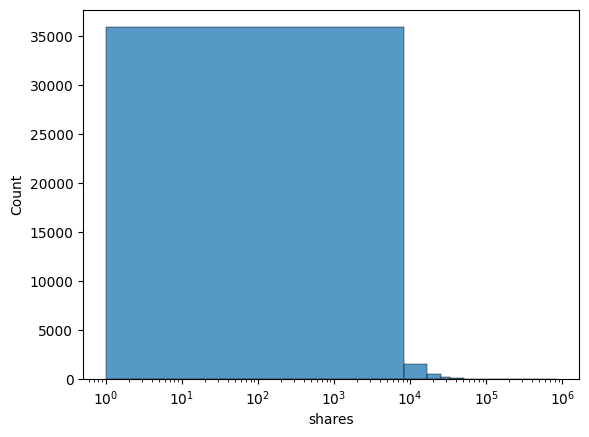

In [9]:
# 檢查欄位的分布（如偏態、極端值）
sns.histplot(df['shares'], bins=100)
plt.xscale('log') # 偏態嚴重

**可從圖表看出目標函數 shares 嚴重偏態，高分享量的文章較少，資料集幾乎都是較低分享量的資料**
->取log值減少偏態，幫助後續的資料分析

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


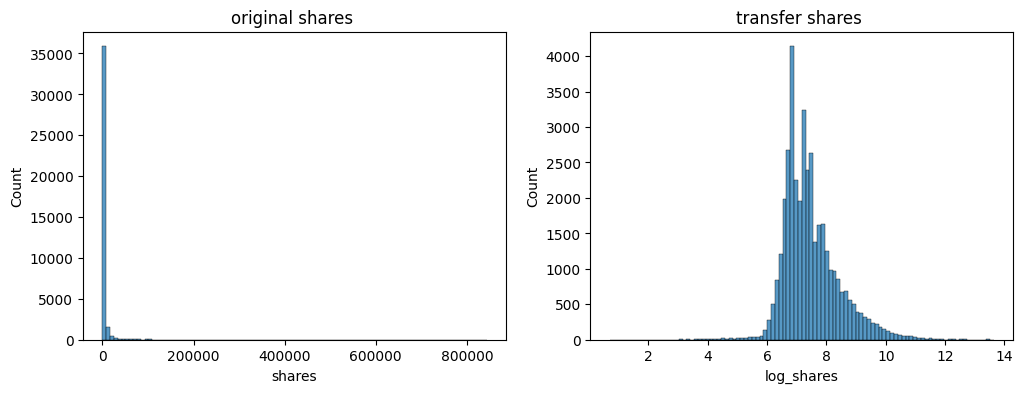

In [10]:
df['log_shares'] = np.log1p(df['shares']) # log1p->log(1+x)，避免x等於0的情況
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # 建立圖表區(1列，2欄，圖大小12寬X4高)
sns.histplot(df['shares'], bins=100, ax=axes[0])
axes[0].set_title('original shares ')
# axes[0].set_yscale('log')
sns.histplot(df['log_shares'], bins=100, ax=axes[1])
axes[1].set_title('transfer shares ')
plt.show()
# 偏態嚴重取log避免偏差過大

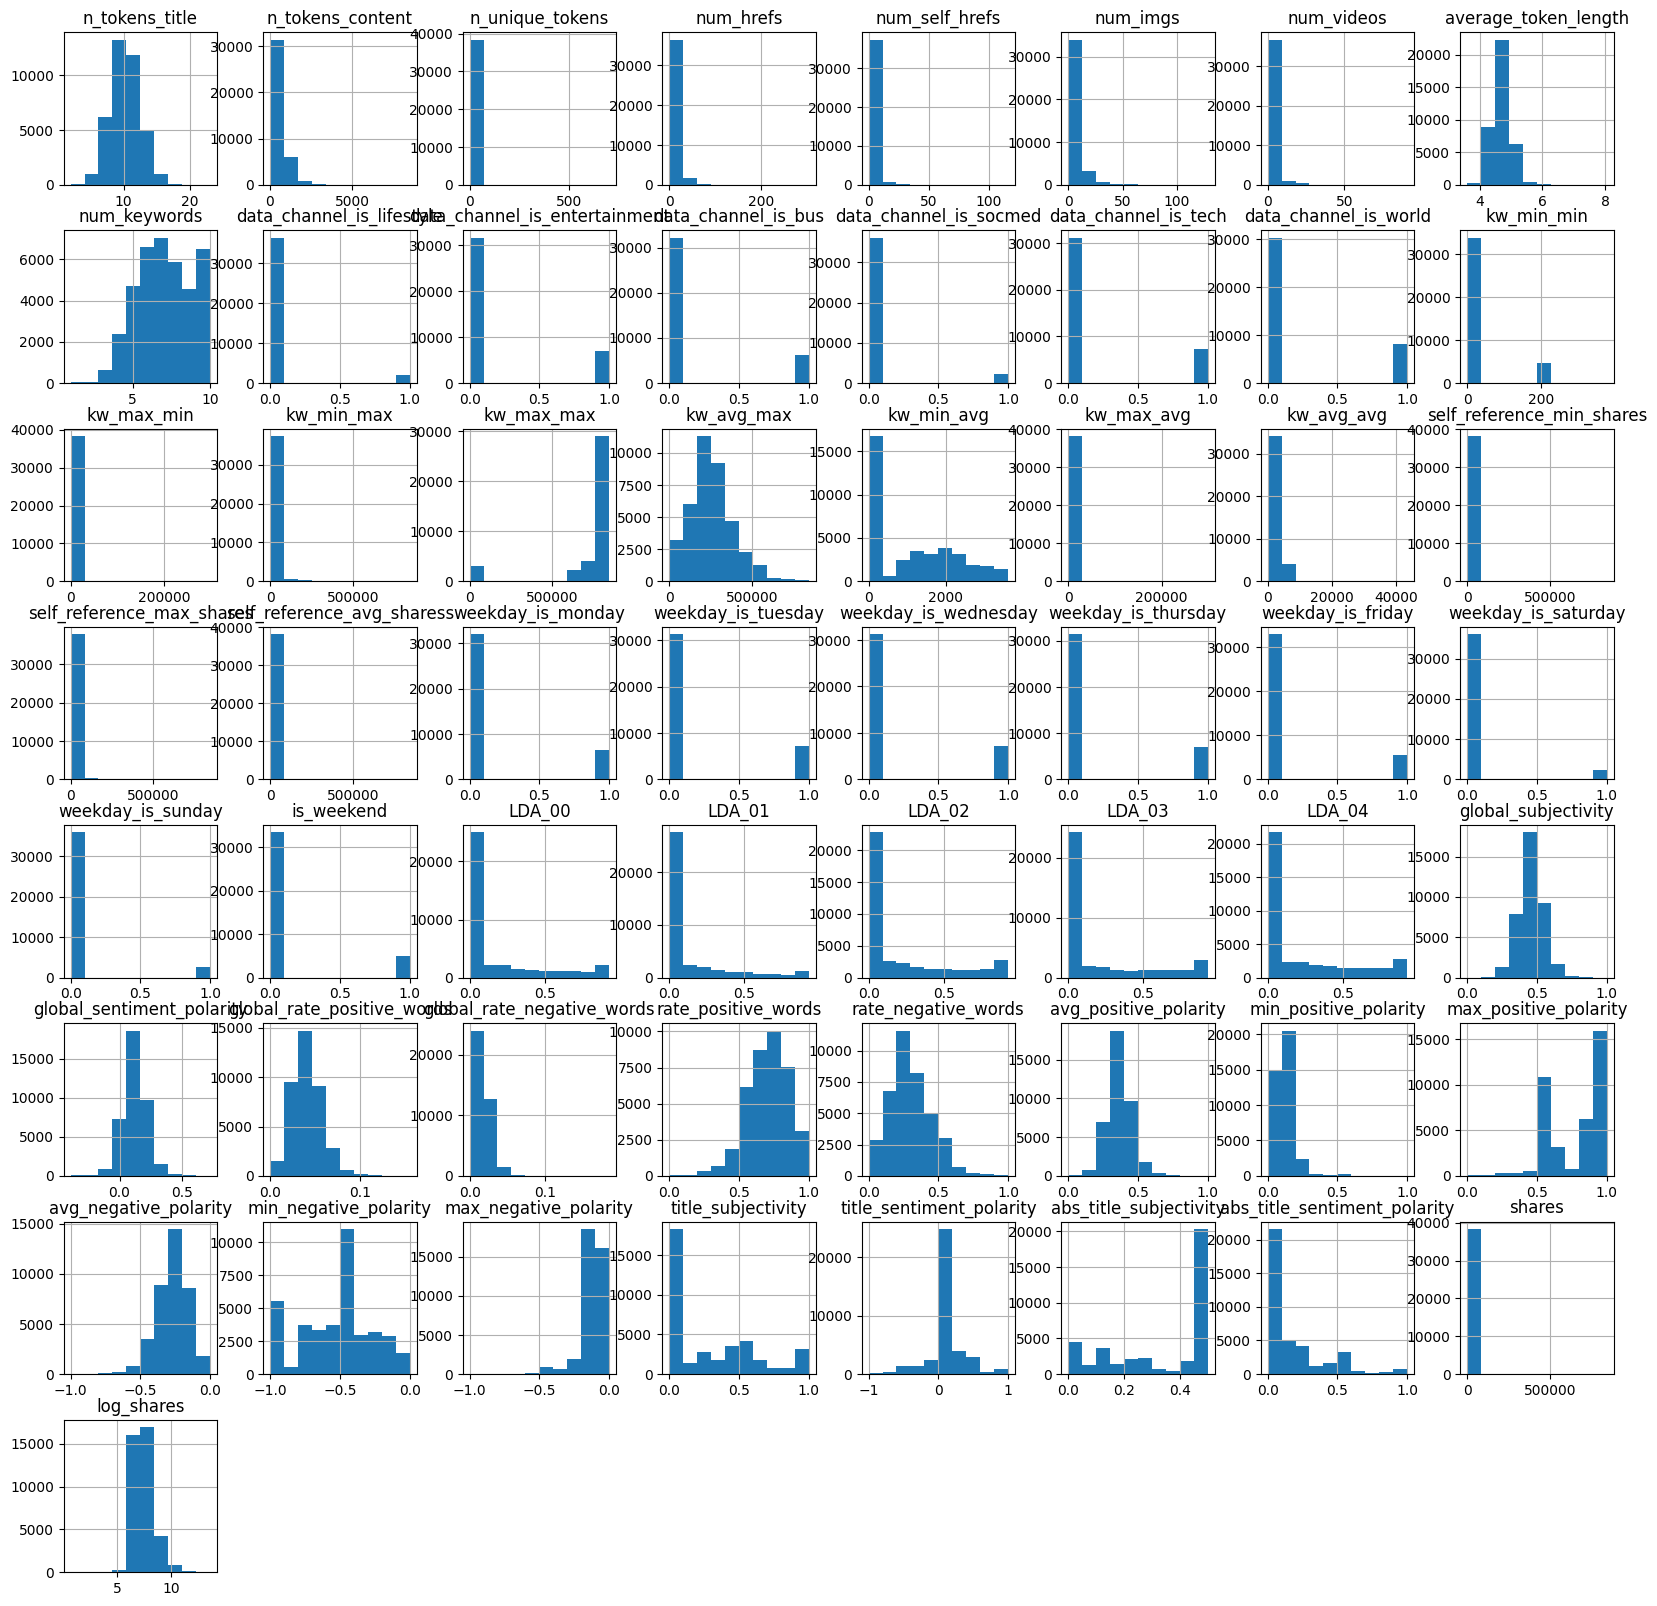

In [11]:
df.hist(figsize=(20,20))
plt.show()

### 3. 觀察資料關係
利用參數和方程式初步查看各特徵與分享量的相關性，後續可能可以挑選特徵使用

log_shares             1.000000
shares                 0.505061
kw_avg_avg             0.221402
global_subjectivity    0.133976
LDA_03                 0.123985
is_weekend             0.116252
num_hrefs              0.114829
kw_max_avg             0.107572
kw_min_avg             0.107479
num_imgs               0.094330
Name: log_shares, dtype: float64
weekday_is_tuesday              -0.031703
min_negative_polarity           -0.036047
weekday_is_wednesday            -0.036229
rate_negative_words             -0.040049
average_token_length            -0.040344
avg_negative_polarity           -0.050784
LDA_01                          -0.051785
data_channel_is_entertainment   -0.081031
data_channel_is_world           -0.155745
LDA_02                          -0.167765
Name: log_shares, dtype: float64


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


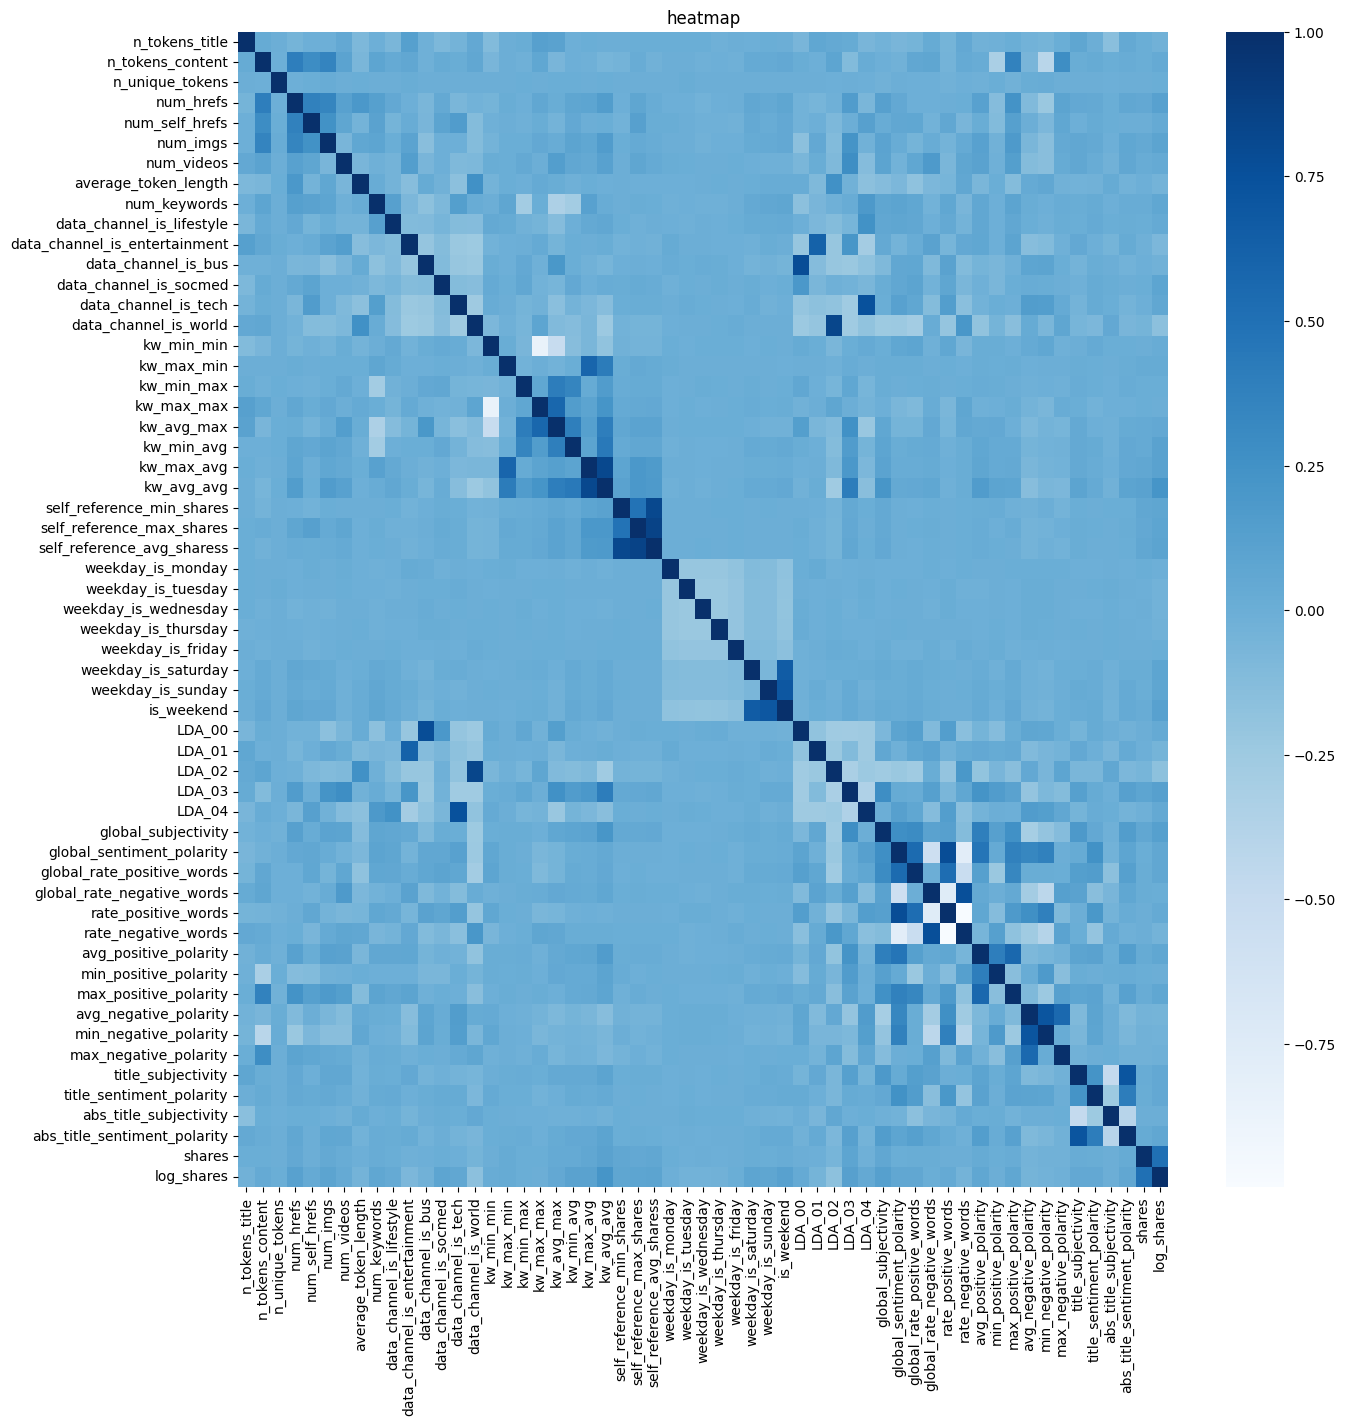

In [12]:
# 與 log_shares 的相關係數排序
correlations = df.corr(numeric_only=True)['log_shares'].sort_values(ascending=False)
print(correlations.head(10))  # 看正相關前10名
print(correlations.tail(10))  # 看負相關前10名

# 熱力圖觀察整體變數間的關係
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(numeric_only=True), cmap='Blues', center=0)
plt.title('heatmap')
plt.show()


## 分類問題：哪些特徵會直接提升分享量？
1. 先將分享量分類：怎樣算高分享量？怎樣算低分享量？
2. 透過多方比較，這裡將資料集切為6:4，分享量較小的那端指標為 low，其餘分類為 high

In [13]:
# 將分享量切成兩等分(由小到大)
df['share_class'] = pd.qcut(df['shares'], q=[0, 0.6, 1.0], labels=['low', 'high'])

In [14]:
# 檢查兩種分布的數量
df['share_class'].value_counts(normalize=True)

share_class
low     0.618698
high    0.381302
Name: proportion, dtype: float64

In [15]:
# 去除不需要的欄位（不使用原始shares）
df = df.drop(['shares', 'log_shares'], axis=1)  # shares 已轉成 log_shares

# 避免 model 預測 log_shares 自己
target = 'share_class'
X = df.drop(columns=[target])
y = df[target]

### SelectKBest：篩選前 K 個「最相關」的特徵
* 一種「特徵選擇」（Feature Selection）方法。
* 根據特定的統計評分方法（例如：f-score、mutual information），選出與目標變數最相關的前 K 個特徵。

In [16]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)

selector = SelectKBest(score_func=chi2, k=55)
X_new = selector.fit_transform(X_scaled, y)

# 查看被選中的特徵名稱
selected_features = selector.get_support(indices=True)
print(X.columns[selected_features])

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max',
       'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg

## 模型建立
## 1. 決策樹
* 監督式學習模型
* 一連串「條件判斷」構成的樹狀結構
* 每個節點根據一個特徵進行「切分」，直到葉節點給出預測值（或類別）
* 注意：決策樹容易過擬合
* 類型：回歸或分類

In [17]:
# 決策樹
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [18]:
# 轉換 y 成數值標籤
le = LabelEncoder()
y_encoded = le.fit_transform(y) 

# 切分訓練與測試資料
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 建立與訓練決策樹模型
dt_model = DecisionTreeClassifier(random_state=3)


In [19]:
# 交叉驗證：使用 StratifiedKFold，保留類別比例
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring='accuracy')
print("交叉驗證準確率（每折）：", cv_scores)
print("交叉驗證平均準確率：", np.mean(cv_scores))

交叉驗證準確率（每折）： [0.59944751 0.59506012 0.58839779 0.59311017 0.59571011]
交叉驗證平均準確率： 0.5943451413714657


In [20]:
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

print("\n測試集準確率：", accuracy_score(y_test, y_pred))
print("分類報告：")
print(classification_report(y_test, y_pred, target_names=le.classes_))


測試集準確率： 0.5858572728454439
分類報告：
              precision    recall  f1-score   support

        high       0.46      0.47      0.46      2929
         low       0.67      0.66      0.66      4764

    accuracy                           0.59      7693
   macro avg       0.56      0.56      0.56      7693
weighted avg       0.59      0.59      0.59      7693



In [21]:
# 取得重要性分數
importances = dt_model.feature_importances_

# 建立 DataFrame 方便排序與觀察
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# 按照重要性排序，列出前幾項
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

print(top_features)

                      feature  importance
22                 kw_avg_avg    0.072424
19                 kw_avg_max    0.036792
45      avg_positive_polarity    0.035724
34                     LDA_00    0.035151
39        global_subjectivity    0.034573
21                 kw_max_avg    0.034362
23  self_reference_min_shares    0.034132
16                 kw_max_min    0.033241
1            n_tokens_content    0.033112
2             n_unique_tokens    0.033067


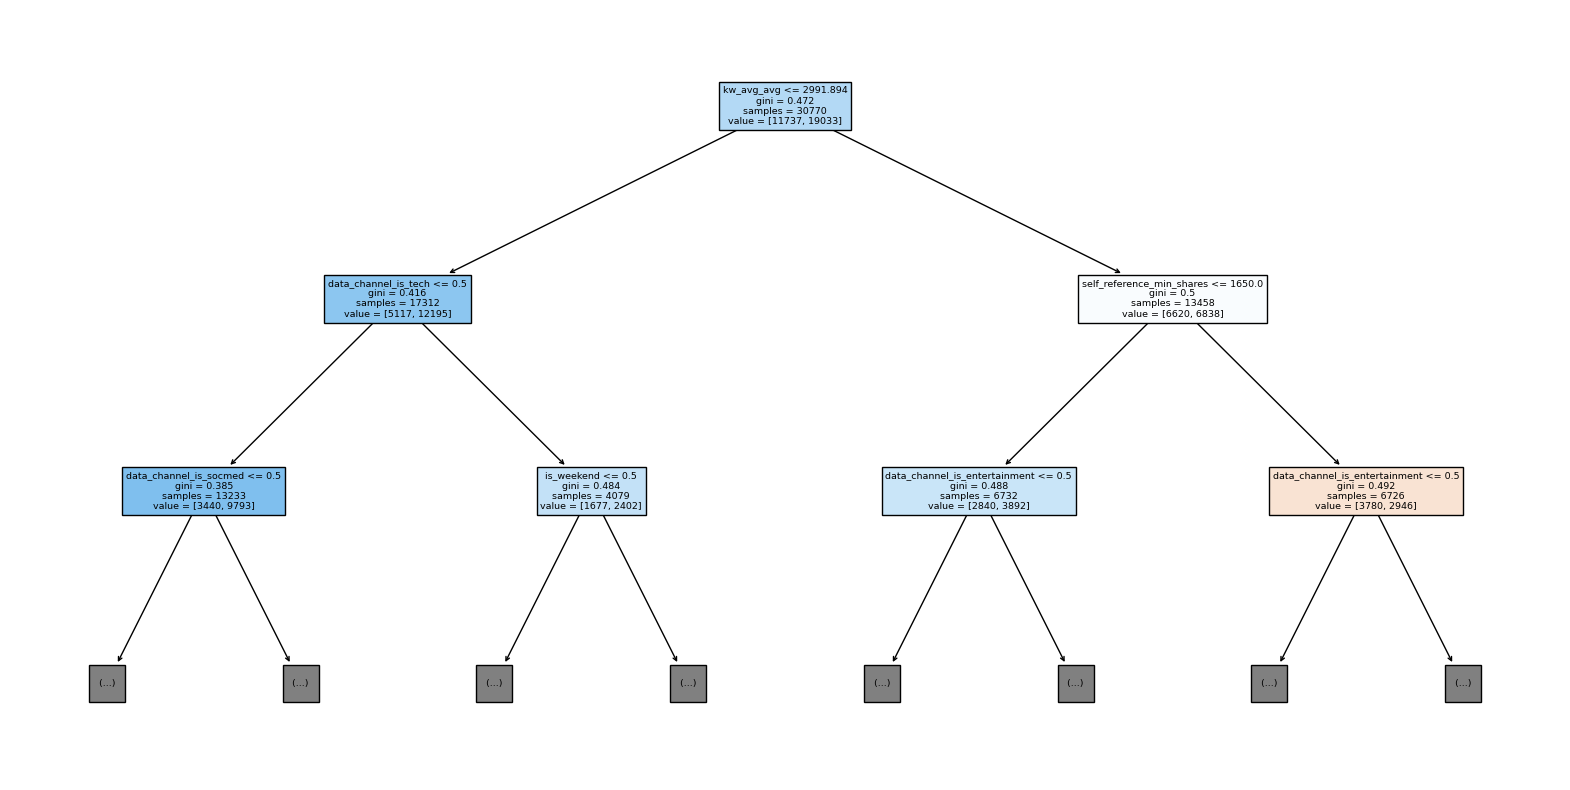

In [22]:
# 視覺了解前幾層是依據哪些特徵進行切割
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, filled=True, max_depth=2)
plt.show()

#### **小結**
1. 決策樹的分類模型較容易過度擬合
2. 測試集及驗證集的準確率都偏低（0.59）

## 2. 隨機數森林
* 集成學習（Ensemble Learning）方法
* Bagging（Bootstrap Aggregating）：每棵樹訓練時隨機抽樣資料（有放回的抽樣）
* 隨機特徵選擇：每個節點只從隨機選出的一小部分特徵中選擇最佳分裂點

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# y 是文字標籤，'low', 'high'，先轉成數值型態
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 資料訓練：切分資料
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
# 利用選中的特徵訓練
# X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# 建立隨機森林模型
rf = RandomForestClassifier(random_state=3)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=3)

In [24]:
# 使用 cross validation 交叉驗證
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# 評估
scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Average accuracy:", scores.mean())

Cross-validation scores: [0.67924344 0.67583114 0.67706708]
Average accuracy: 0.6773805552982576


In [25]:
# 訓練整個訓練集
rf.fit(X_train, y_train)

# 在測試集上評估模型
print("Test set 準確率：", rf.score(X_test, y_test))

Test set 準確率： 0.6784089431951125


In [26]:
rf_pred = rf.predict(X_test)

# 印出分類報告
print(classification_report(y_test, rf_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        high       0.61      0.42      0.50      2929
         low       0.70      0.84      0.76      4764

    accuracy                           0.68      7693
   macro avg       0.66      0.63      0.63      7693
weighted avg       0.67      0.68      0.66      7693



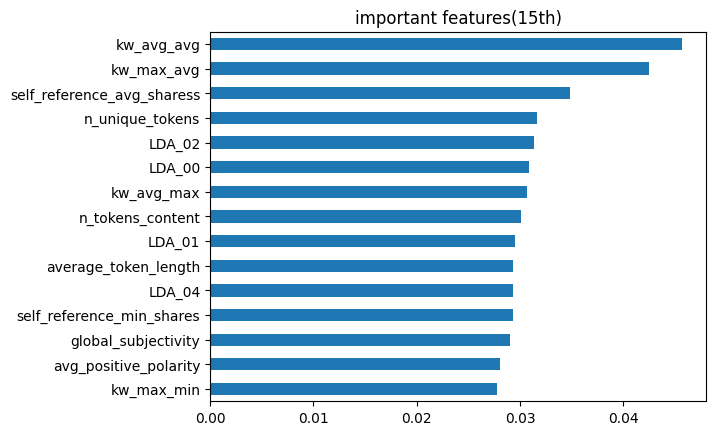

In [27]:
# 查看特徵重要性
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('important features(15th)')
plt.gca().invert_yaxis()
plt.show()

#### **小結**
1. 隨機森林的準確度明顯較決策樹好（0.68）
2. 隨機森林的模型結果中，以「關鍵字中平均分享數的關鍵字的平均值」（kw_avg_avg）為最重要的特徵，說明統計數字中較容易被分享的關鍵字為網路文章被分享的關鍵指標

## 3. XGboost

In [28]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# 將目標轉成數值
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 根據類別分佈給權重
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
sample_weights = np.array([class_weights[label] for label in y_train])

# 使用 Stratified K-Fold，確保每折中類別比例一致
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)
scores = []

# 手動執行交叉驗證，使用 accuracy 做為評估指標
# sample_weight無法直接傳進交叉驗證中，需手動跑回圈
for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    sw_tr = sample_weights[train_idx]

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        learning_rate=0.05,
        max_depth=5,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=3
    )
    xgb_model.fit(X_tr, y_tr, sample_weight=sw_tr)
    y_pred = xgb_model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    scores.append(acc)

In [29]:
print(f'Cross-validation accuracy scores: {scores}')
print(f'Mean CV accuracy: {np.mean(scores):.4f}')

Cross-validation accuracy scores: [0.671053914399922, 0.6678365993955347, 0.6635140405616224]
Mean CV accuracy: 0.6675


In [30]:
# 用全部的訓練集重新訓練一次模型（準備測試用）
xgb_model.fit(X_train, y_train)

# 在測試集上評估泛化效果
xgb_pred = xgb_model.predict(X_test)
print(classification_report(y_test, xgb_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        high       0.62      0.45      0.52      2929
         low       0.71      0.83      0.77      4764

    accuracy                           0.69      7693
   macro avg       0.67      0.64      0.65      7693
weighted avg       0.68      0.69      0.68      7693



##### **小結**
1. XGBoost 的準確率較隨機森林高一點（0.69）

## 4. LightGBM

In [31]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 將目標轉成數值
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 建立 LightGBM 回歸模型
lgbm = lgb.LGBMClassifier(random_state=42)

In [32]:
# 訓練模型
lgbm.fit(X_train, y_train)

# 使用 Stratified K-Fold，確保每折中類別比例一致
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=3)

# 執行交叉驗證，使用 accuracy 做為評估指標
scores = cross_val_score(lgbm, X_train, y_train, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracy scores: {scores}')
print(f'Mean CV accuracy: {np.mean(scores):.4f}')

[LightGBM] [Info] Number of positive: 19033, number of negative: 11737
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7681
[LightGBM] [Info] Number of data points in the train set: 30770, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618557 -> initscore=0.483428
[LightGBM] [Info] Start training from score 0.483428
[LightGBM] [Info] Number of positive: 9516, number of negative: 5869
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7598
[LightGBM] [Info] Number of data points in the train set: 15385, number of used features: 55
[LightGBM] [Info] [bin

In [33]:
lgbm.fit(X_train, y_train)

# 在測試集上評估泛化效果
lgbm_pred = lgbm.predict(X_test)
print(classification_report(y_test, lgbm_pred, target_names=le.classes_))

[LightGBM] [Info] Number of positive: 19033, number of negative: 11737
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7681
[LightGBM] [Info] Number of data points in the train set: 30770, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618557 -> initscore=0.483428
[LightGBM] [Info] Start training from score 0.483428
              precision    recall  f1-score   support

        high       0.62      0.45      0.52      2929
         low       0.71      0.83      0.77      4764

    accuracy                           0.69      7693
   macro avg       0.67      0.64      0.65      7693
weighted avg       0.68      0.69      0.67      7693



#### **四種模型比較**
1. 整體準確率 (Accuracy)
    * XGBoost 和 LightGBM 以些微差距勝出（0.69 vs 0.68），但差異不大，代表整體分類表現相近。
2. Macro F1-score（平衡三類的重要指標）
    * XGBoost 和 LightGBM 的 Macro F1-score 同為 0.65，略勝一籌，表示它們在兩類（high、low）上表現較平衡。
3. 中間類別（medium）的表現
    * XGBoost 與 LightGBM 在 high 類別有相同表現，F1-score 為 0.52；隨機森林稍差，但三者皆有待提升。
4. 低類別 (low) 和 高類別 (high)
    * 三個模型在 low 類別表現接近，但 XGBoost 與 LightGBM Precision 較高，整體稍優。
  
**繼續調整 XGBoost，LightGBM當輔助**

## 調整 XGBoost 參數

In [34]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# 將目標轉成數值
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 使用 SMOTE 調整類別不平衡
# 建立 Pipeline：SMOTE + XGBoost
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=3
    ))
])

# 利用 sklearn 的 GridSearch 自動尋找最佳參數
# GridSearch 的參數空間
param_grid = {
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [4, 5],
    'classifier__n_estimators': [300, 400],
    'classifier__reg_alpha': [0, 0.1],
    'classifier__reg_lambda': [1.0, 2.0],
}

# 設定 GridSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv, # 這裡交叉驗證
    error_score='raise',
    verbose=1,
    n_jobs=-1
)

# 查看最佳結果
grid_search.fit(X_train, y_train)
print("最佳參數組合：", grid_search.best_params_)
print("最佳準確率：", grid_search.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
最佳參數組合： {'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 400, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 1.0}
最佳準確率： 0.6844978710428519


In [35]:
# 在驗證集上評估泛化效果
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        high       0.62      0.48      0.54      2929
         low       0.72      0.82      0.77      4764

    accuracy                           0.69      7693
   macro avg       0.67      0.65      0.65      7693
weighted avg       0.68      0.69      0.68      7693



In [36]:
# 抓出特徵重要性
importance = xgb_model.get_booster().get_score(importance_type='gain')

# 整理成 DataFrame 排序
importance_df = pd.DataFrame(importance.items(), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print(importance_df.head(10))

                          Feature  Importance
10  data_channel_is_entertainment   42.573032
13           data_channel_is_tech   37.035187
14          data_channel_is_world   33.853531
22                     kw_avg_avg   29.736965
12         data_channel_is_socmed   28.358055
33                     is_weekend   28.281101
25     self_reference_avg_sharess   23.574194
31            weekday_is_saturday   19.343470
18                     kw_max_max   18.547308
23      self_reference_min_shares   15.998999


## 結論


**目標函數：分享量（shares）**
**模型最終準確率：69%**


根據模型訓練後的重要性排序可以得知結果如下：(依特徵的資訊增益排序）
1.  data_channel_is_entertainment
    * 對預測分享量貢獻最大，顯示其在資料中與高分享量存在顯著關聯
2.  data_channel_is_tech
    * 科技類文章也高度吸引人，顯示特定受眾對新知有較高分享意願
3.  data_channel_is_world
    * 國際議題對某些族群有強烈共鳴，可能具有社會討論價值，具一定話題性
4.  kw_avg_avg
    * 文章關鍵字的整體熱門程度影響分享數，顯示熱門關鍵字的使用會提升擴散力
5.  data_channel_is_socmed
    * 可能反映與社群互動相關的內容會有較高曝光與轉發
  
依據特徵重要性前10名，可將主要影響分享量的特徵分為三種：內容主題（data_channel）、關鍵字熱度（kw_avg_avg、kw_max_max）、以及發文時間（is_weekend、weekday_is_saturday）。
**內容主題**是影響分享量的關鍵因素，並以娛樂、科技與國際新聞頻道為關鍵類型，其資訊增益明顯高於其他特徵，這顯示不同主題類型對讀者分享意願有顯著影響。
**文章所使用的關鍵字熱門程度**也具重要預測力，說明選擇熱門且具吸引力的關鍵字，有助提升文章的擴散能力。
**發文時間**週末（尤其是週六）是提升分享量的重要時段，顯示週末讀者較有空閒且更容易分享文章。

根據 XGBoost 模型的特徵重要性分析結果，娛樂類文章在判斷分享量高低上貢獻最大，顯示其在資料中與高分享量存在顯著關連，但並不代表所有娛樂文章都會被大量分享，分享量仍受到熱門關鍵字選擇、發布時間及來源表現等多重因素影響。未來若想提升文章擴散效果，建議可在考量主題的同時，結合其他影響因子一併優化發文策略。